# Import Libraries and Data

In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Dropout , Flatten , Activation , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [41]:
def create_data(path):
    label = []
    data = []
    # Get list of folders in path
    folder = os.listdir(path)
    for i in folder:
        # Create full path of the folder
        folder_path = os.path.join(path, i)
        # Create list of files in folders
        folder_list = os.listdir(folder_path)
        # Iterate through each file in the folder
        for file in folder_list:
            # Create full path to the file
            file_path = os.path.join(folder_path, file)
            label.append(i)
            data.append(file_path)
    # Convert list (label, data) to pandas dataframe
    data_path = pd.Series(data, name='filepath')
    label = pd.Series(label, name='label')
    return pd.concat([data_path, label], axis=1)

In [42]:
def load_data():
    base_dir = './data'
    training_path = os.path.join(base_dir, 'training')
    validation_path = os.path.join(base_dir, 'validation')
    evaluation_path = os.path.join(base_dir, 'evaluation')

    train_data = create_data(training_path)
    val_data = create_data(validation_path)
    eval_data = create_data(evaluation_path)

    return train_data, val_data, eval_data

train_data, val_data, eval_data = load_data()

# Display first few rows of the training data
train_data.head()

,filepath,label
0,./data\training\Dessert\0.jpg,Dessert
1,./data\training\Dessert\1.jpg,Dessert
2,./data\training\Dessert\10.jpg,Dessert
3,./data\training\Dessert\100.jpg,Dessert
4,./data\training\Dessert\1000.jpg,Dessert


In [43]:
print(train_data.shape)
print(val_data.shape)
print(eval_data.shape)

(3504, 2)
(1226, 2)
(1181, 2)


# Data Preparation

In [44]:
# parameters
image_size = 224
image_channel = 3
bat_size = 32

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)


test_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
train_generator = train_datagen.flow_from_dataframe(train_data,
                                                    x_col= 'filepath',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(val_data, 
                                                 x_col= 'filepath',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(eval_data, 
                                                  x_col= 'filepath',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 3504 validated image filenames belonging to 4 classes.
Found 1226 validated image filenames belonging to 4 classes.
Found 1181 validated image filenames belonging to 4 classes.


# Data Exploration 

In [47]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : Dessert
1 : Noodles-Pasta
2 : Seafood
3 : Vegetable-Fruit


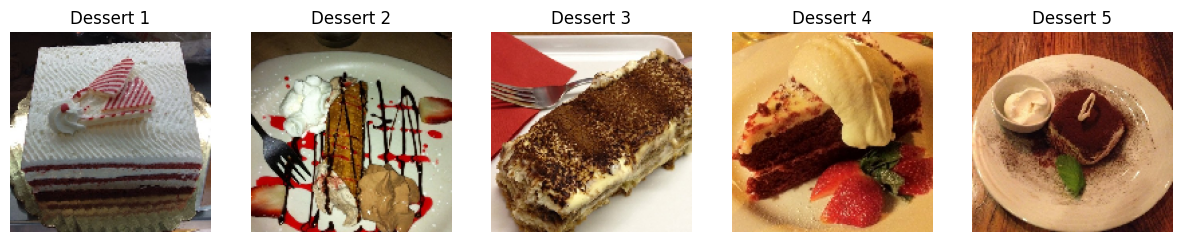

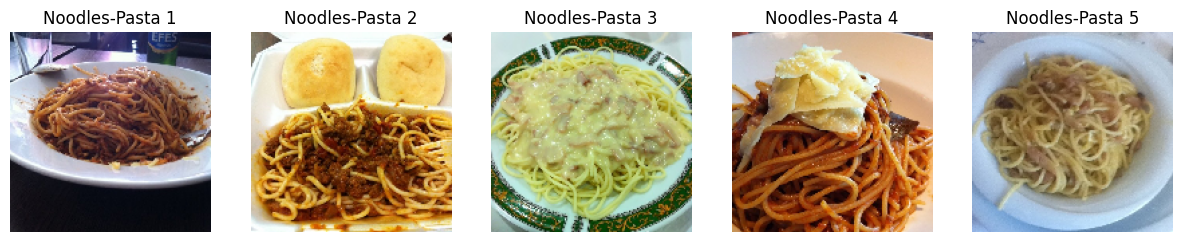

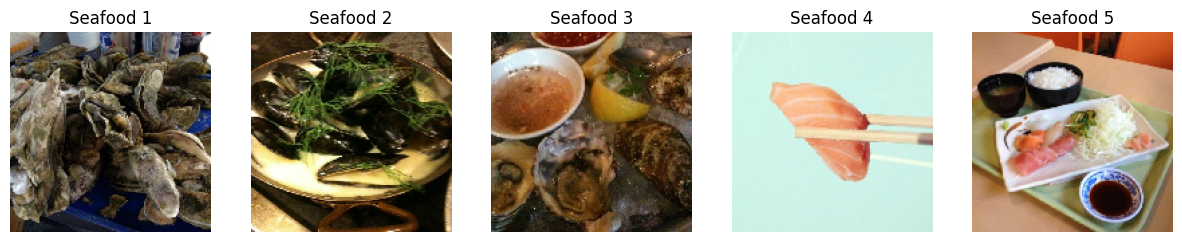

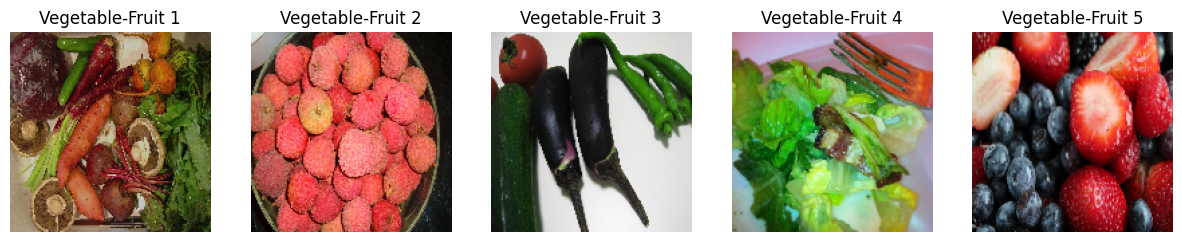

In [48]:
# Function to display images from multiple classes
def display_images_by_class(parent_folder, n_images=5):
    # Get the list of class folders
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

# Path to the parent directory containing class folders
parent_folder = './data/training'

# Display images for each class in the parent folder
display_images_by_class(parent_folder, n_images=5)

# Modeling

In [49]:
import efficientnet.tfkeras as efn
base_model = efn.EfficientNetB7(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [50]:
# Add Extra Layers to Model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x) 
x=Dense(32,activation='relu')(x) 
out=Dense(4,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=out)

base_model.trainable = False

In [51]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [52]:
history = model.fit(train_generator,epochs=20,validation_data=val_generator, callbacks=[ES,RL])

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.6902 - loss: 0.7339 - val_accuracy: 0.9038 - val_loss: 0.2635 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.8730 - loss: 0.3285 - val_accuracy: 0.9046 - val_loss: 0.2508 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8806 - loss: 0.3302 - val_accuracy: 0.9176 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8785 - loss: 0.3194 - val_accuracy: 0.9209 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8870 - loss: 0.2971 - val_accuracy: 0.9331 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9119 - loss: 0.2314 - val_accuracy: 0.9282 - val_loss: 0.2044 - learning_rate: 0.0010
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9087 - loss: 0.

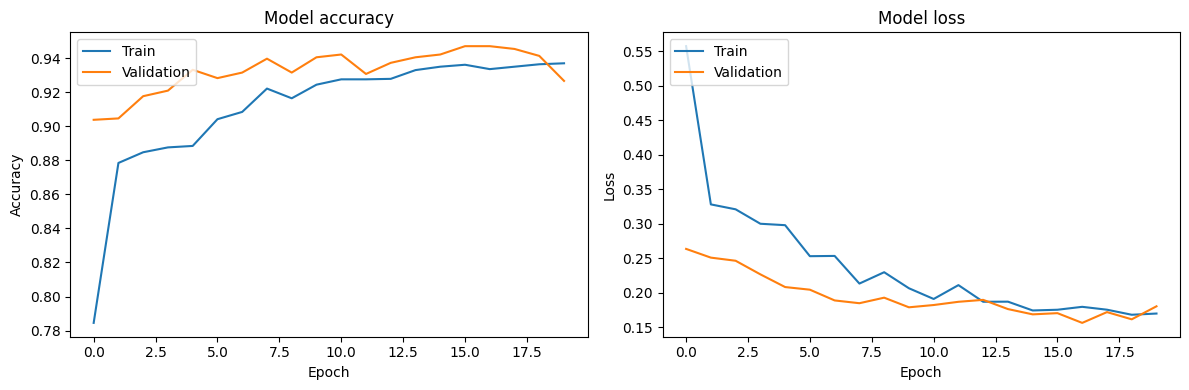

In [53]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluation

In [54]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

The accuracy of the model for training data is: 96.94634675979614
The Loss of the model for training data is: 0.07858368009328842
The accuracy of the model for test data is: 94.8348879814148
The Loss of the model for test data is: 0.13600441813468933


In [55]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

37/37 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step


**Confusion Matrix**

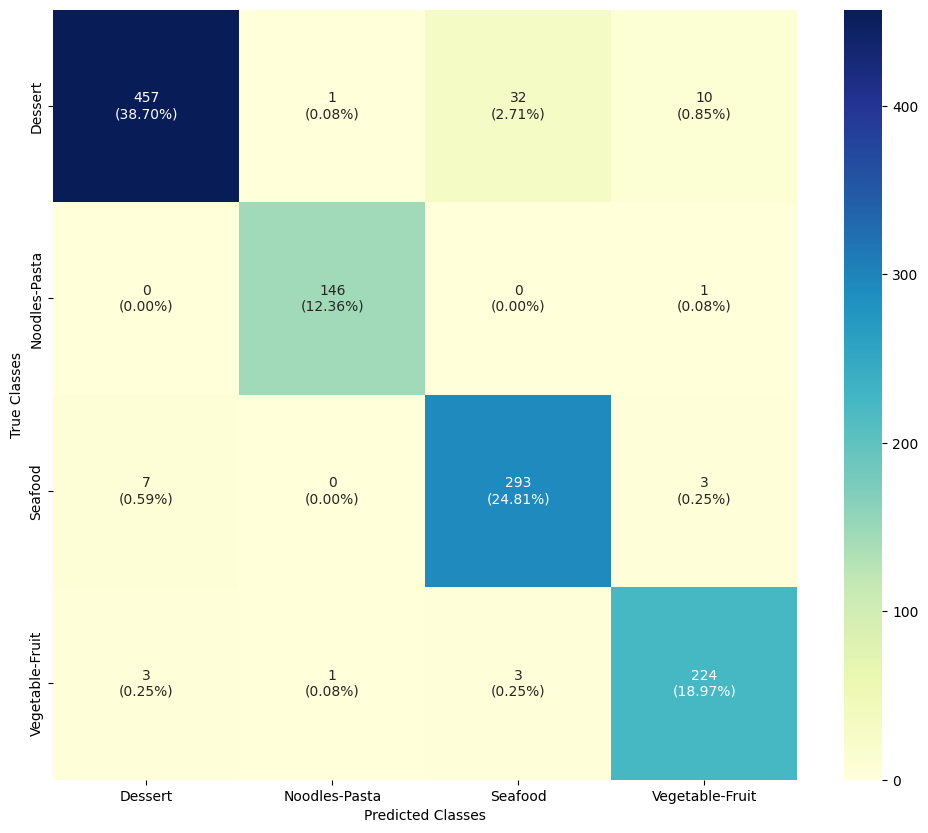

In [56]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**Classification Report**

In [57]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                 precision    recall  f1-score   support

        Dessert       0.98      0.91      0.95       500
  Noodles-Pasta       0.99      0.99      0.99       147
        Seafood       0.89      0.97      0.93       303
Vegetable-Fruit       0.94      0.97      0.96       231

       accuracy                           0.95      1181
      macro avg       0.95      0.96      0.95      1181
   weighted avg       0.95      0.95      0.95      1181



**Display Some Images With Predictions**

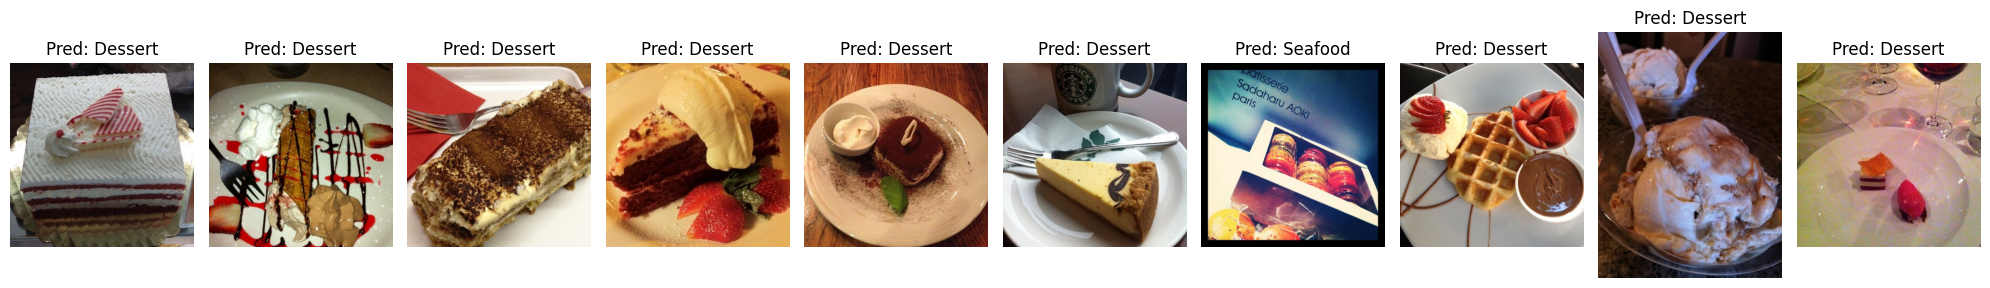

In [58]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)

# Save model

In [59]:
model.save("./model/model.h5")  

In [60]:
from tensorflow import keras

model = keras.models.load_model('./model/model.h5')